In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlns-dataset/data2.npy
/kaggle/input/mlns-dataset/data1.npy
/kaggle/input/mlns-dataset/data0.npy
/kaggle/input/mlns-dataset/lab2.npy
/kaggle/input/mlns-dataset/lab1.npy
/kaggle/input/mlns-dataset/lab0.npy


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Multiply

In [3]:
# def load_data():
#     data0 = np.load('/kaggle/input/mlns-dataset/data0.npy')
#     data1 = np.load('/kaggle/input/mlns-dataset/data1.npy')
#     data2 = np.load('/kaggle/input/mlns-dataset/data2.npy')
#     lab0 = np.load('/kaggle/input/mlns-dataset/lab0.npy')
#     lab1 = np.load('/kaggle/input/mlns-dataset/lab1.npy')
#     lab2 = np.load('/kaggle/input/mlns-dataset/lab2.npy')

#     # Combine data and labels
#     data = np.concatenate([data0, data1, data2], axis=0)
#     labels = np.concatenate([lab0, lab1, lab2], axis=0)

#     return data, labels

def load_data():
    data0 = np.load('data0.npy')
    data1 = np.load('data1.npy')
    data2 = np.load('data2.npy')
    lab0 = np.load('lab0.npy')
    lab1 = np.load('lab1.npy')
    lab2 = np.load('lab2.npy')

    # Combine data and labels
    data = np.concatenate([data0, data1, data2], axis=0)
    labels = np.concatenate([lab0, lab1, lab2], axis=0)

    return data, labels

In [4]:
def preprocess_data(data, labels):
    # Normalize images to the range [0, 1]
    data = data / 255.0
    # Add channel dimension for grayscale images
    data = np.expand_dims(data, axis=-1)
    # Add noise for robustness
    noise_factor = 0.05
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    data = np.clip(noisy_data, 0., 1.)
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        data, labels, test_size=0.2, random_state=42
    )
    return X_train, X_val, y_train, y_val

In [5]:
def visualize_data(data, labels, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(data[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    # First Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    # Second Convolutional Block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    # Third Convolutional Block
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    # Attention Mechanism
    attention = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
    x = Multiply()([x, attention])  # Element-wise multiplication
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer for regression (integer prediction)
    outputs = Dense(1, activation='linear')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
def create_data_generator():
    return ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        fill_mode='nearest'
    )

In [8]:
def train_model():

    # Load and preprocess data
    data, labels = load_data()
    X_train, X_val, y_train, y_val = preprocess_data(data, labels)
    # Build model
    model = build_model(input_shape=X_train.shape[1:])
    # Compile the model
    optimizer = Adam(learning_rate=0.0005)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',  
        metrics=['mean_absolute_error']  
    )

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        ),
        ModelCheckpoint(
            'best_model_regression.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=40,
        batch_size=32,
        callbacks=callbacks
    )
    return model, history

In [9]:
def evaluate_model(model, X_val, y_val):
    predictions = model.predict(X_val)
    
    mse = np.mean((y_val - predictions.flatten()) ** 2)
    mae = np.mean(np.abs(y_val - predictions.flatten()))
    rmse = np.sqrt(mse)
    
    accuracy_1 = np.mean(np.abs(y_val - predictions.flatten()) <= 0.5) * 100
    accuracy_2 = np.mean(np.abs(y_val - predictions.flatten()) <= 1.0) * 100
    accuracy_3 = np.mean(np.abs(y_val - predictions.flatten()) <= 2.0) * 100
    
    print(f"Validation Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Validation Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Accuracy (±0.5 digit): {accuracy_1:.1f}%")
    print(f"Accuracy (±1 digits): {accuracy_2:.1f}%")
    print(f"Accuracy (±2 digits): {accuracy_3:.1f}%")
    
    plt.figure(figsize=(15, 6))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X_val[i].squeeze(), cmap='gray')
        error = abs(y_val[i] - predictions[i][0])
        color = 'green' if error <= 1.0 else 'red'
        plt.title(f"True: {y_val[i]:.1f}\nPred: {predictions[i][0]:.1f}\nErr: {error:.1f}", 
                 color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return predictions


In [10]:
# Train the model
model, history = train_model()

Epoch 1/40
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 263.4852 - mean_absolute_error: 14.7646
Epoch 1: val_loss improved from inf to 15.92297, saving model to best_model_regression.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 60ms/step - loss: 263.2256 - mean_absolute_error: 14.7541 - val_loss: 15.9230 - val_mean_absolute_error: 3.2051 - learning_rate: 5.0000e-04
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 28.9080 - mean_absolute_error: 4.2756
Epoch 2: val_loss did not improve from 15.92297
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - loss: 28.9046 - mean_absolute_error: 4.2753 - val_loss: 19.6298 - val_mean_absolute_error: 3.5724 - learning_rate: 5.0000e-04
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 19.5251 - mean_absolute_error: 3.4998
Epoch 3: val_loss improved from 15.92297 to 7.93624, saving model to best_model_regression.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - loss: 19.5228 - mean_absolute_error: 3.4996 - val_loss: 7.9362 - val_mean_

In [53]:
model = load_model('best_model_regression.keras')

938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step
Validation Mean Absolute Error (MAE): 0.35
Validation Root Mean Squared Error (RMSE): 0.50
Accuracy (±0.5 digit): 76.2%
Accuracy (±1 digits): 96.3%
Accuracy (±2 digits): 99.5%


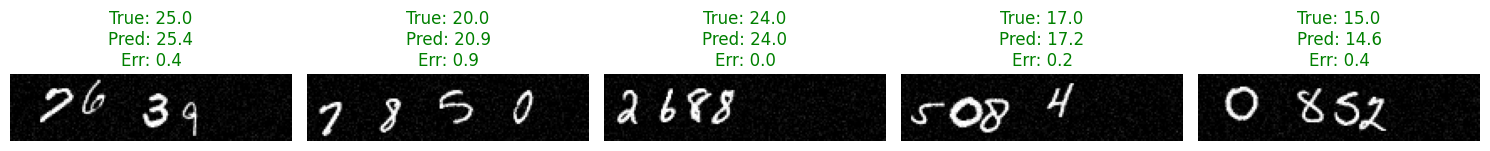

array([[25.358128],
       [20.87609 ],
       [23.991674],
       ...,
       [22.141323],
       [19.27607 ],
       [17.321909]], dtype=float32)

In [11]:
data, labels = load_data()
X_train, X_val, y_train, y_val = preprocess_data(data, labels)

evaluate_model(model, np.concatenate((X_train, X_val), axis=0), np.concatenate((y_train, y_val), axis=0))

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Validation Mean Absolute Error (MAE): 0.43
Validation Root Mean Squared Error (RMSE): 0.65
Accuracy (±0.5 digit): 70.1%
Accuracy (±1 digits): 93.0%
Accuracy (±2 digits): 98.6%


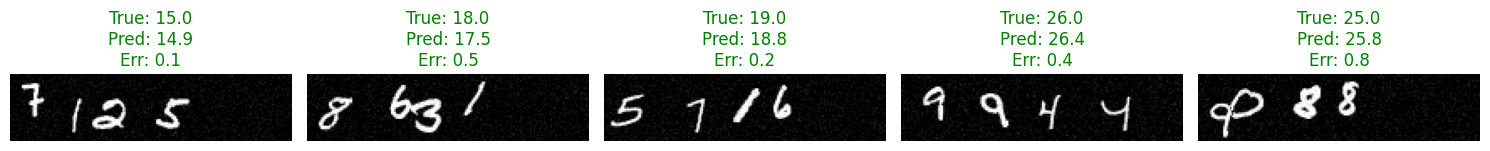

array([[14.949516],
       [17.500769],
       [18.84254 ],
       ...,
       [22.141323],
       [19.27607 ],
       [17.321909]], dtype=float32)

In [12]:
evaluate_model(model, X_val, y_val)